##**Problem statement:** 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## **Importing Skin Cancer Data**

### First Importing all the important libraries

In [3]:
!pip install layers

  Created wheel for layers: filename=layers-0.1.5-py3-none-any.whl size=5379 sha256=0d70e7d14a7a1efb4de90ff13b805adde3a316ec81fa0ef3fb6ac5da3799fb38
  Stored in directory: /root/.cache/pip/wheels/75/6f/32/757f357608178c55254f10906905e7f8cd63b566173377c819
  Created wheel for bashutils: filename=Bashutils-0.0.4-py3-none-any.whl size=5472 sha256=943687710398498444ff1756b9d6de1bd0bb2191b48ab30851351c45d5a7895b
  Stored in directory: /root/.cache/pip/wheels/c7/a0/9a/b99da313eb952e5d8ab2622528c0102544d5cddca1ffc9b15e
Successfully built layers bashutils


In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from glob import glob

In [5]:
## using the data by mounting the google drive:
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
## Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Creating a dataset

Defining some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [9]:
## Writing the train dataset here
## Using seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing images to the size img_height*img_width, while writing the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2,subset='training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Writing the validation dataset here
## Using seed=123 while creating the dataset using tf.keras.preprocessing.image_dataset_from_directory
## resizing images to the size img_height*img_width, while writing the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2,subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualizing the data

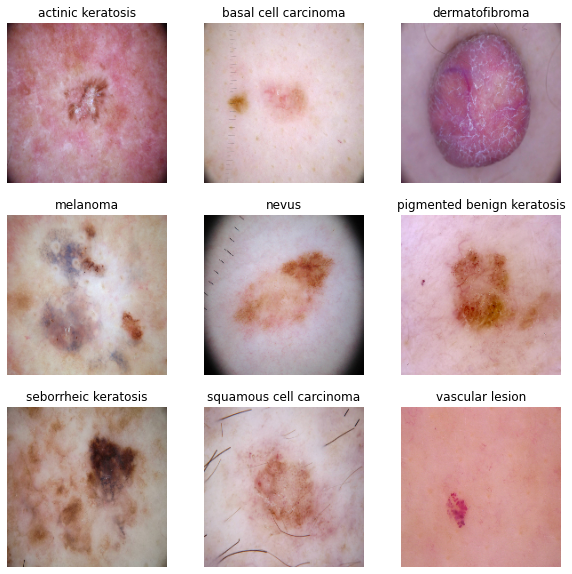

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:

preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [15]:

model= Sequential([
tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
layers.Conv2D(16,3,padding='same',activation='relu'),
layers.MaxPool2D(),

layers.Conv2D(32,3,padding='same',activation='relu'),
layers.MaxPool2D(),

layers.Conv2D(64,3,padding='same',activation='relu'),
layers.MaxPool2D(),

layers.Flatten(),
layers.Dense(128,activation='relu'),
layers.Dense(9,activation='softmax'),
])

## Number of classes is 9 (same mentioned in last Dense layer)


### Compiling the model
Choosing an appropirate optimiser and loss function for model training 

In [16]:

### Using adam optimiser and using SparseCategoricalCrossentropy loss function for this classification problem
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# Viewing the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Training the model

In [18]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 93s 1s/step - loss: 1.8768 - accuracy: 0.3198 - val_loss: 1.7093 - val_accuracy: 0.3400
Epoch 2/20
56/56 [==============================] - 1s 15ms/step - loss: 1.5283 - accuracy: 0.4693 - val_loss: 1.5246 - val_accuracy: 0.4720
Epoch 3/20
56/56 [==============================] - 1s 15ms/step - loss: 1.3909 - accuracy: 0.5251 - val_loss: 1.3706 - val_accuracy: 0.5369
Epoch 4/20
56/56 [==============================] - 1s 15ms/step - loss: 1.2828 - accuracy: 0.5385 - val_loss: 1.4685 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 1s 15ms/step - loss: 1.2335 - accuracy: 0.5631 - val_loss: 1.3321 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 1s 15ms/step - loss: 1.1457 - accuracy: 0.6004 - val_loss: 1.3556 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 1s 15ms/step - loss: 1.0757 - accuracy: 0.6127 - val_loss: 1.3869 - val_accuracy: 0.5459
Epoch 8/20
56/56 [=======

### Visualizing training results

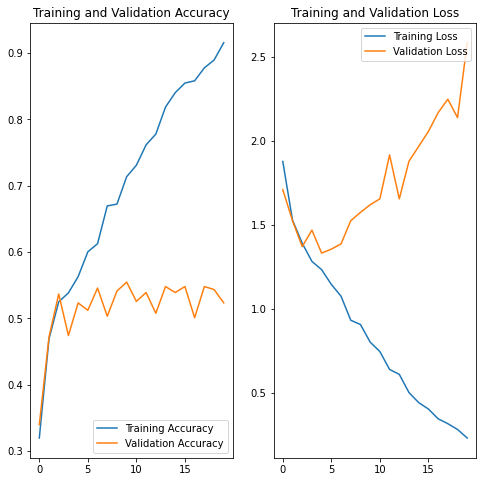

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings from above model

After seeing the above graphs, it is clear that this is a case of **OVERFITTING**.
Training accuracy has increased in every epoch, but the validation accuracy is not increasing. Similarly, the training loss has decreased, but corresponding decrease in validation loss has not occured.
There is a big gap between the accuracies at the end of 20 epochs.

### Selecting Augmentation strategy to overcome Overfitting

In [20]:
# choosing an appropriate data augumentation strategy. 
from keras.preprocessing.image import ImageDataGenerator

In [21]:
datagen = ImageDataGenerator(
        
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = class_names,
    batch_size = 32
 )



Found 2239 images belonging to 9 classes.


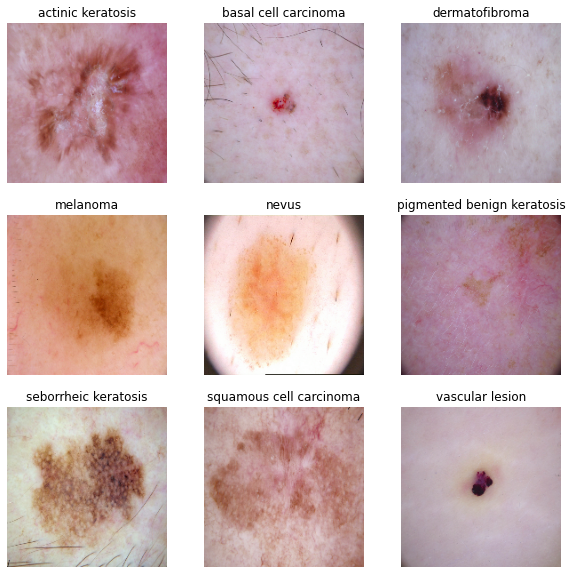

In [22]:
# visualizing how the augmentation strategy worked for one instance of training image.
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')


### Creating the model, compiling and training the model


In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model= Sequential([
tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
layers.Conv2D(16,3,padding='same',activation='relu'),
layers.MaxPool2D(),
layers.Dropout(0.25),

layers.Conv2D(32,3,padding='same',activation='relu'),
layers.MaxPool2D(),
layers.Dropout(0.25),

layers.Conv2D(64,3,padding='same',activation='relu'),
layers.MaxPool2D(),
layers.Dropout(0.25),

layers.Flatten(),
layers.Dense(128,activation='relu'),
layers.Dense(9,activation='softmax'),
])

## Number of classes is 9

### Compiling the model

In [24]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [26]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 2s 19ms/step - loss: 2.4380 - accuracy: 0.1847 - val_loss: 2.0644 - val_accuracy: 0.2081
Epoch 2/20
56/56 [==============================] - 1s 16ms/step - loss: 2.0125 - accuracy: 0.2333 - val_loss: 2.0065 - val_accuracy: 0.2483
Epoch 3/20
56/56 [==============================] - 1s 16ms/step - loss: 1.8760 - accuracy: 0.3147 - val_loss: 1.8221 - val_accuracy: 0.3647
Epoch 4/20
56/56 [==============================] - 1s 16ms/step - loss: 1.6871 - accuracy: 0.3761 - val_loss: 1.7547 - val_accuracy: 0.3758
Epoch 5/20
56/56 [==============================] - 1s 16ms/step - loss: 1.5945 - accuracy: 0.4235 - val_loss: 1.7136 - val_accuracy: 0.3915
Epoch 6/20
56/56 [==============================] - 1s 16ms/step - loss: 1.5234 - accuracy: 0.4576 - val_loss: 1.5636 - val_accuracy: 0.4340
Epoch 7/20
56/56 [==============================] - 1s 16ms/step - loss: 1.4783 - accuracy: 0.4782 - val_loss: 1.5867 - val_accuracy: 0.4765
Epoch 8/20
56/56 [======

### Visualizing the results

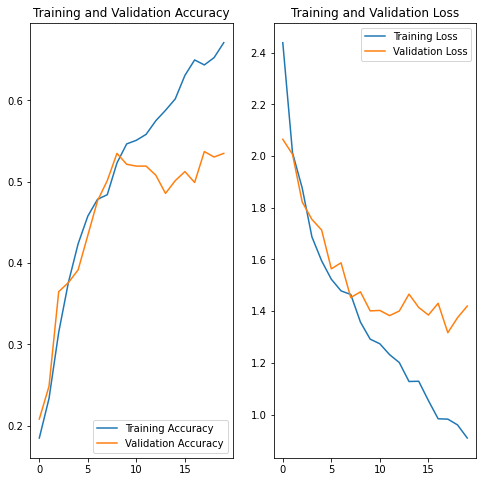

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Findings**: 
As evidnet from the above graph, The model is now **UNDERFITTING**.
It has improved from the previous model, but the accuracies have gone down and still there is big gap between training and validation dataset accuracies.
Same is with the reduction in losses.

### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

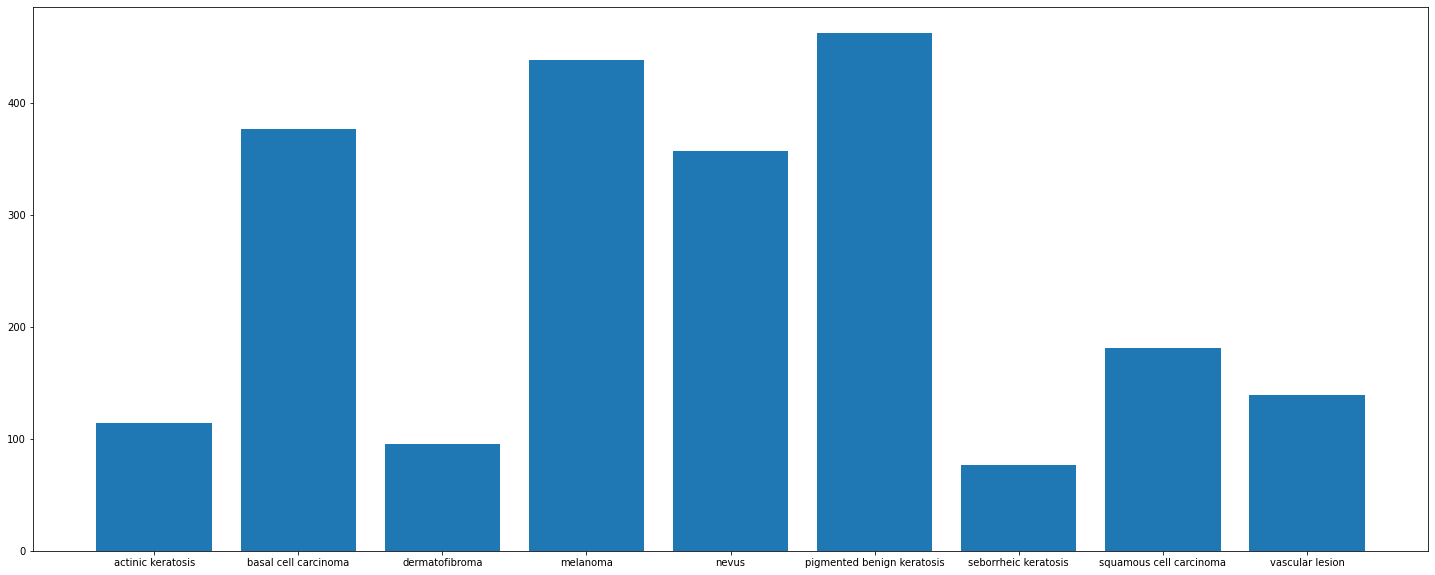

In [28]:
## Your code goes here.
import matplotlib.pyplot as plt
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
There is a big issue of class imbalance and needs to be solved in order to remove Overfitting
#### - Which class has the least number of samples?
**seborrheic keratosis** Class has least number of samples.
**dermatofibroma**,**actinic keratosis** and **vascular lesion** classes also have relatively less samples compared to other classes.
#### - Which classes dominate the data in terms proportionate number of samples?
**pigmented benign keratosis** has the largest number of samples. Apart from this, **basal cell caricnoma**, **melanoma** and **nevus** are next 3 dominating classes in terms of avialable number of sample images.


### Rectifying the class imbalance
#### **Context:** We will use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 
    ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE3F5996F50>: 100%|██████████| 500/500 [00:09<00:00, 54.41 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE3F59773D0>: 100%|██████████| 500/500 [00:09<00:00, 55.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE3F58DB6D0>: 100%|██████████| 500/500 [00:09<00:00, 54.92 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE3F593DFD0>: 100%|██████████| 500/500 [00:41<00:00, 12.10 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FE3F58CCE50>: 100%|██████████| 500/500 [00:39<00:00, 12.64 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE3F5967D50>: 100%|██████████| 500/500 [00:08<00:00, 55.94 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FE3F59DF2D0>: 100%|██████████| 500/500 [00:19<00:00, 25.11 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE480496CD0>: 100%|██████████| 500/500 [00:08<00:00, 56.11 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE3F59BA250>: 100%|██████████| 500/500 [00:08<00:00, 57.05 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010407.jpg_8578c976-58cb-4814-aedb-e66ce94708c9.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010329.jpg_d909691c-c2e6-42f8-b0a8-6406e200572e.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010690.jpg_ceba35b2-52f2-4776-aa63-277e65266a27.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010029.jpg_64746fbe-375c-4417-ae0c-16c5c86c3ca5.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000553.jpg_538aac8d-da12-40ba-a26d-2d29d7d7585a.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [34]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [36]:
new_df['Label'].value_counts()

melanoma                      500
actinic keratosis             500
dermatofibroma                500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
vascular lesion               500
basal cell carcinoma          500
squamous cell carcinoma       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Training the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### Creating a training dataset

In [38]:
data_dir_train="/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Creating a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Creating the model (including normalization)

In [40]:
## your code goes here
model= Sequential([
tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
layers.Conv2D(16,3,padding='same',activation='relu'),
layers.Dropout(0.25),
layers.MaxPool2D(),


layers.Conv2D(32,3,padding='same',activation='relu'),
layers.Dropout(0.25),
layers.MaxPool2D(),

layers.Conv2D(64,3,padding='same',activation='relu'),
layers.Dropout(0.25),
layers.MaxPool2D(),

layers.Flatten(),
layers.Dense(128,activation='relu'),
layers.Dense(9,activation='softmax'),
])

## Number of classes is 9

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [41]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 dropout_3 (Dropout)         (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)        0         
                                                      

#### **Todo:**  Train your model

In [43]:

## using 30 epochs.
epochs = 30
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 18s 101ms/step - loss: 1.9966 - accuracy: 0.2404 - val_loss: 1.7822 - val_accuracy: 0.3927
Epoch 2/30
169/169 [==============================] - 18s 101ms/step - loss: 1.5260 - accuracy: 0.4273 - val_loss: 1.5969 - val_accuracy: 0.4484
Epoch 3/30
169/169 [==============================] - 18s 101ms/step - loss: 1.2812 - accuracy: 0.5249 - val_loss: 1.3931 - val_accuracy: 0.5167
Epoch 4/30
169/169 [==============================] - 18s 105ms/step - loss: 1.1418 - accuracy: 0.5916 - val_loss: 1.3112 - val_accuracy: 0.5063
Epoch 5/30
169/169 [==============================] - 18s 101ms/step - loss: 0.9906 - accuracy: 0.6506 - val_loss: 1.2911 - val_accuracy: 0.5241
Epoch 6/30
169/169 [==============================] - 18s 101ms/step - loss: 0.8919 - accuracy: 0.6895 - val_loss: 1.3041 - val_accuracy: 0.5145
Epoch 7/30
169/169 [==============================] - 18s 101ms/step - loss: 0.8049 - accuracy: 0.7177 - val_loss: 1.0335 - val_accuracy: 0.6

#### **Todo:**  Visualize the model results

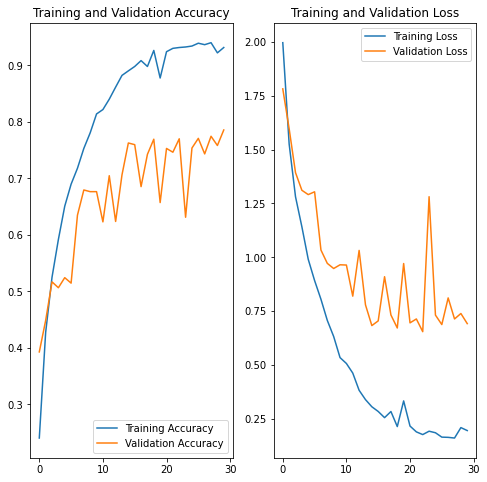

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Analyzing results here. 



The class rebalance helped in reducing overfititng of the data and thus the losses were reduced and accuracies increased


Augumentation library helped in removing overfitting and resulted in accuracies of Training and Validation sets to be higher and comparatively closer